In [2]:
!python -m spacy download en # one time run

     |████████████████████████████████| 11.1MB 4.4MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.1.0-cp35-none-any.whl size=11075235 sha256=84eb61b38059e630f9554a2528ccbf10dfd41deafb85c037375a9cb3d4670f1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-r3jwrx8v/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f
Successfully built en-core-web-sm
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/en_core_web_sm -->
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [4]:
df = pd.read_json('abstract_1.json', lines=True)
df.head()


,abstract
0,The rapid increasing of online information is ...
1,Keywords are very important for any academic p...
2,Paper presents a survey of methods and approac...
3,Every year thousands of academic studies are p...
4,"We describe latent Dirichlet allocation (LDA),..."


In [5]:
df.iloc[0:5]

,abstract
0,The rapid increasing of online information is ...
1,Keywords are very important for any academic p...
2,Paper presents a survey of methods and approac...
3,Every year thousands of academic studies are p...
4,"We describe latent Dirichlet allocation (LDA),..."


In [6]:
data = df.iloc[0:5].values.tolist()
print(data)

[['The rapid increasing of online information is hard to handle.Summaries such as abstracts help us to reduce this problem. Keywords, whichcan be regarded as very short summaries, may help even more. Filteringdocuments by using keywords may save precious time while searching.However, most of the documents do not include keywords. In this paper wepresent a model that extracts keywords from abstracts and titles. This model hasbeen implemented in a prototype system. We have tested our model on a set ofabstracts of Academic papers containing keywords composed by their authors.Results show that keywords extracted from abstracts and titles may be a primarytool for researchers.'], ['Keywords are very important for any academic paper. We propose the Perceptron Training Rule for keyword extraction from titles and abstracts. We present a system for generating keywords which relies on weights of words in a sentence. The system generates keywords from academic research articles by selecting the mo

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words)

[['the', 'rapid', 'increasing', 'of', 'online', 'information', 'is', 'hard', 'to', 'handle', 'summaries', 'such', 'as', 'abstracts', 'help', 'us', 'to', 'reduce', 'this', 'problem', 'keywords', 'whichcan', 'be', 'regarded', 'as', 'very', 'short', 'summaries', 'may', 'help', 'even', 'more', 'by', 'using', 'keywords', 'may', 'save', 'precious', 'time', 'while', 'searching', 'however', 'most', 'of', 'the', 'documents', 'do', 'not', 'include', 'keywords', 'in', 'this', 'paper', 'wepresent', 'model', 'that', 'extracts', 'keywords', 'from', 'abstracts', 'and', 'titles', 'this', 'model', 'hasbeen', 'implemented', 'in', 'prototype', 'system', 'we', 'have', 'tested', 'our', 'model', 'on', 'set', 'ofabstracts', 'of', 'academic', 'papers', 'containing', 'keywords', 'composed', 'by', 'their', 'authors', 'results', 'show', 'that', 'keywords', 'extracted', 'from', 'abstracts', 'and', 'titles', 'may', 'be', 'primarytool', 'for', 'researchers'], ['keywords', 'are', 'very', 'important', 'for', 'any', '

In [8]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

['rapid increasing online information be hard handle summary such abstract help reduce problem keyword whichcan be regard very short summary may help even more use keyword may save precious time search however most document do not include keyword paper wepresent model extract keyword abstract title model hasbeen implement prototype system have test model set ofabstract academic paper contain keyword compose author result show keyword extract abstract title may be primarytool researcher', 'keyword be very important academic paper propose perceptron training rule keyword extraction title abstract present system generate keyword rely weight word sentence system generate keyword academic research article select most relevant keyword compare keyword generate system generate cluster analysis keyword give author analyze result base full keyword match partial keyword match keyword match', 'paper present survey method approach keyword extraction task addition systematization method paper gather

In [9]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)


In [10]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  24.830917874396135 %


In [11]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=6,               # Number of topics
                                      max_iter=50,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=1,            # n docs in each learning iter
                                      evaluate_every = 1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=1, doc_topic_prior=None,
             evaluate_every=1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=6, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [12]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2139.7058854499164
Perplexity:  219.1348664676938
{'batch_size': 1,
 'doc_topic_prior': None,
 'evaluate_every': 1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 50,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 6,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [92]:
# Define Search Param
search_params = {'n_components': [2,5,10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be chang

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be chang

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [2, 5, 10, 15, 20], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [93]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))


Best Model's Params:  {'n_components': 2, 'learning_decay': 0.9}
Best Log Likelihood Score:  -926.1407066421714
Model Perplexity:  203.22124457734742


In [94]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

In [83]:
print(data_vectorized)

  (0, 0)	3
  (0, 1)	1
  (0, 11)	1
  (0, 25)	1
  (0, 29)	1
  (0, 47)	1
  (0, 59)	2
  (0, 77)	1
  (0, 78)	1
  (0, 79)	1
  (0, 80)	2
  (0, 83)	1
  (0, 85)	1
  (0, 86)	1
  (0, 89)	1
  (0, 92)	6
  (0, 105)	3
  (0, 112)	1
  (0, 114)	1
  (0, 115)	2
  (0, 121)	1
  (0, 127)	1
  (0, 130)	1
  (0, 135)	1
  (0, 140)	1
  :	:
  (4, 91)	1
  (4, 94)	1
  (4, 95)	2
  (4, 96)	1
  (4, 98)	1
  (4, 102)	1
  (4, 104)	3
  (4, 105)	7
  (4, 106)	1
  (4, 116)	1
  (4, 124)	1
  (4, 128)	2
  (4, 129)	2
  (4, 136)	1
  (4, 148)	1
  (4, 149)	1
  (4, 152)	1
  (4, 164)	2
  (4, 179)	1
  (4, 181)	3
  (4, 187)	4
  (4, 191)	1
  (4, 192)	2
  (4, 193)	1
  (4, 198)	1


In [84]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [67]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(data_vectorized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [68]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [69]:
for i in range(true_k):
 print("Cluster %d:" % i),
 for ind in order_centroids[i, :20]:
   print(' %s' % terms[ind])

Cluster 0:
 model
 topic
 mixture
 text
 probabilistic
 underlying
 document
 collection
 probability
 lda
 set
 representation
 explicit
 discrete
 result
 efficient
 dirichlet
 empirical
 datum
 estimation
Cluster 1:
 keyword
 abstract
 method
 academic
 publication
 use
 extraction
 generate
 paper
 study
 result
 search
 propose
 base
 title
 problem
 text
 match
 extract
 research


In [96]:

# column names
topicnames = ["Topic" + str(i) for i in range(2)]
#print(topicnames)

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
#print(docnames)

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(25).style.applymap(color_green).applymap(make_bold)
df_document_topics
#df_document_topic.Topic0

In [97]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,4
1,0,1


In [98]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics            x           y
topic                                                     
1      58.413247        1       1  2352.815430 -5514.87207
0      41.586753        1       2 -2352.815186  5514.87207, topic_info=     Category      Freq          Term      Total  loglift  logprob
term                                                              
137   Default  4.000000   publication   4.000000  30.0000  30.0000
172   Default  3.000000         study   3.000000  29.0000  29.0000
196   Default  4.000000           use   4.000000  28.0000  28.0000
0     Default  7.000000      abstract   7.000000  27.0000  27.0000
105   Default  5.000000         model   5.000000  26.0000  26.0000
60    Default  4.000000    extraction   4.000000  25.0000  25.0000
44    Default  2.000000    discipline   2.000000  24.0000  24.0000
159   Default  2.000000       section   2.000000  23.0000  23.0000
1     Default  4.000000      academic   4.000000  22.0000  22.0000
158   Default  3.000000        search   3.000000  21.0000  21.0000
115   Default  3.000000         paper   3.000000  20.0000  20.0000
70    Default  1.000000    generation   1.000000  19.0000  19.0000
101   Default  1.000000       measure   1.000000  18.0000  18.0000
12    Default  3.000000          base   3.000000  17.0000  17.0000
139   Default  1.000000       quickly   1.000000  16.0000  16.0000
126   Default  1.000000      previous   1.000000  15.0000  15.0000
169   Default  1.000000         solve   1.000000  14.0000  14.0000
2     Default  1.000000      accurate   1.000000  13.0000  13.0000
151   Default  2.000000    researcher   2.000000  12.0000  12.0000
38    Default  1.000000    derivation   1.000000  11.0000  11.0000
130   Default  2.000000       problem   2.000000  10.0000  10.0000
97    Default  1.000000          look   1.000000   9.0000   9.0000
109   Default  1.000000           nlp   1.000000   8.0000   8.0000
194   Default  1.000000    university   1.000000   7.0000   7.0000
28    Default  1.000000   conjunction   1.000000   6.0000   6.0000
202   Default  2.000000          word   2.000000   5.0000   5.0000
182   Default  1.000000      textrank   1.000000   4.0000   4.0000
35    Default  1.000000          data   1.000000   3.0000   3.0000
33    Default  1.000000         cover   1.000000   2.0000   2.0000
64    Default  1.000000   furthermore   1.000000   1.0000   1.0000
...       ...       ...           ...        ...      ...      ...
194    Topic2  0.891868    university   1.415592   0.4154  -5.2210
28     Topic2  0.903627   conjunction   1.442413   0.4097  -5.2079
109    Topic2  0.910438           nlp   1.454745   0.4087  -5.2004
182    Topic2  0.884666      textrank   1.428968   0.3979  -5.2291
64     Topic2  0.863204   furthermore   1.394989   0.3974  -5.2537
147    Topic2  0.859875        remove   1.394043   0.3942  -5.2575
138    Topic2  0.871008       publish   1.419655   0.3889  -5.2447
90     Topic2  0.877031  introduction   1.430031   0.3885  -5.2378
33     Topic2  0.898195         cover   1.467854   0.3862  -5.2139
99     Topic2  0.867484          make   1.417809   0.3861  -5.2487
171    Topic2  0.873516     structure   1.428973   0.3852  -5.2418
35     Topic2  0.908994          data   1.488286   0.3843  -5.2020
125    Topic2  0.897312       prevent   1.469527   0.3841  -5.2149
122    Topic2  0.893621     precision   1.465912   0.3824  -5.2190
190    Topic2  0.849613        turkey   1.395200   0.3814  -5.2695
1      Topic2  2.945674      academic   4.952280   0.3579  -4.0262
151    Topic2  1.322744    researcher   2.326071   0.3129  -4.8268
130    Topic2  1.342792       problem   2.389400   0.3011  -4.8118
202    Topic2  1.307970          word   2.369753   0.2831  -4.8381
102    Topic2  2.595135        method   6.525163  -0.0446  -4.1529
152    Topic2  1.730603        result   3.752791   0.1034  -4.5581
181    Topic2  1.701712          text   3.761036   0.0843  -4.5749
92     Topic2  4.612264       keywor

In [99]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
#print(df_topic_keywords)


In [100]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,keyword,abstract,publication,use,academic,study,method,search,result,text,section,discipline,problem,propose,generation
Topic 1,keyword,model,method,extraction,paper,base,generate,topic,abstract,text,research,present,match,document,result


In [103]:
df_document_topic.iloc[0][1]

0.98

In [104]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["my favourite topic is image processing"]
topic, prob_scores = predict_topic(text = mytext)
print(" about the topics")
print(topic)
print(" probability scores")
print(prob_scores)

TypeError: 'list' object is not callable

In [106]:
list=[]
list=df_topic_keywords.iloc[int(df_document_topic.iloc[2][1])].tolist()
list

['keyword',
 'abstract',
 'publication',
 'use',
 'academic',
 'study',
 'method',
 'search',
 'result',
 'text',
 'section',
 'discipline',
 'problem',
 'propose',
 'generation']

In [29]:
!pip install -U nltk


     |████████████████████████████████| 1.5MB 2.8MB/s eta 0:00:01�███████████████▋| 1.4MB 2.8MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.4.5-cp35-none-any.whl size=1450717 sha256=a421a09dbf41c05f013523f723fc07c9cde826bb52697c98b02fcdff019e2645
  Stored in directory: /home/nbuser/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.1
    Uninstalling nltk-3.2.1:
      Successfully uninstalled nltk-3.2.1
You should consider upgrading via the 'pip install --upgrade pip' command.


In [30]:
!pip install -U rake_nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=10089 sha256=90c5f9894558dbcd83a1c4a819a235c0d4f5b9cf37975ee2bc0454795e7b354e
  Stored in directory: /home/nbuser/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
def convert(list): 
      
    # Converting integer list to string list 
    s = [str(i) for i in list] 
      
    # Join list items using join() 
    res = (" ".join(s)) 
    
    return(res) 
  

convert_list=convert(list)

In [32]:
from rake_nltk import Rake

r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.
r.extract_keywords_from_text(convert_list)
    #r.get_ranked_phrases_with_scores() # To get keyword phrases ranked highest to lowest.
print(r.get_word_degrees())
print(r.get_word_frequency_distribution())

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x7f49829a1d08>, {'approach': 15, 'extraction': 15, 'graph': 15, 'new': 15, 'task': 15, 'method': 15, 'base': 15, 'keyword': 15, 'elaborate': 15, 'graphbase': 15, 'unsupervised': 15, 'candidate': 15, 'exist': 15, 'research': 15, 'paper': 15})
Counter({'approach': 1, 'extraction': 1, 'unsupervised': 1, 'new': 1, 'task': 1, 'method': 1, 'base': 1, 'keyword': 1, 'elaborate': 1, 'graphbase': 1, 'graph': 1, 'candidate': 1, 'exist': 1, 'research': 1, 'paper': 1})


In [33]:
list

['keyword',
 'extraction',
 'method',
 'paper',
 'base',
 'unsupervised',
 'graph',
 'new',
 'approach',
 'research',
 'exist',
 'graphbase',
 'elaborate',
 'candidate',
 'task']

In [34]:
r.extract_keywords_from_text(df['abstract'][2])
    #r.get_ranked_phrases_with_scores() # To get keyword phrases ranked highest to lowest.

print(r.get_word_degrees())
print(r.get_word_frequency_distribution())

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x7f4982951c80>, {'work': 2, 'network': 2, 'systematization': 1, 'provides': 3, 'task': 3, 'tfidf': 3, 'method': 4, 'addition': 1, 'survey': 1, 'gathers': 2, 'review': 2, 'complex': 2, 'comprehensive': 2, 'methods': 5, 'guidelines': 3, 'graph': 5, 'candidates': 2, 'research': 4, 'extracts': 2, 'nodes': 2, 'supervised': 1, 'future': 2, 'extraction': 15, 'special': 2, 'emphasis': 2, 'new': 5, 'related': 2, 'approaches': 3, 'well': 1, 'development': 1, 'proposed': 1, 'keyword': 17, 'based': 6, 'elaborated': 1, 'presents': 2, 'unsupervised': 5, 'paper': 7, 'selectivity': 1, 'croatian': 3, 'existing': 2, 'graphbased': 2})
Counter({'keyword': 6, 'extraction': 5, 'methods': 3, 'paper': 3, 'based': 2, 'graph': 2, 'new': 2, 'approaches': 2, 'unsupervised': 2, 'research': 2, 'special': 1, 'network': 1, 'systematization': 1, 'provides': 1, 'work': 1, 'selectivity': 1, 'method': 1, 'survey': 1, 'tfidf': 1, 'existing': 1

In [35]:
def checkKey(dict, key): 
      
    if key in dict.keys(): 
        print(key,end=", ")
        print("Present, ", end =" ") 
        print("value =", dict[key]) 
        return dict[key]
    else: 
        print("Not present") 
        return 0

In [36]:
final_keywords=[]
for i in range(0,len(list)):
    result=checkKey(r.get_word_degrees(),list[i])
    if(result>2):
        final_keywords.append(list[i])
        


keyword, Present,  value = 17
extraction, Present,  value = 15
method, Present,  value = 4
paper, Present,  value = 7
Not present
unsupervised, Present,  value = 5
graph, Present,  value = 5
new, Present,  value = 5
Not present
research, Present,  value = 4
Not present
Not present
Not present
Not present
task, Present,  value = 3


In [37]:
print(final_keywords)

['keyword', 'extraction', 'method', 'paper', 'unsupervised', 'graph', 'new', 'research', 'task']


In [38]:
dataset=pd.read_json("sample_1.json",lines=True)
dataset.head()

,abstract
0,Paper presents a survey of methods and approac...


In [39]:
#Fetch wordcount for each abstract
dataset['word_count'] = dataset['abstract'].apply(lambda x: len(str(x).split(" ")))
dataset[['abstract','word_count']].head()

,abstract,word_count
0,Paper presents a survey of methods and approac...,93


In [40]:
##Descriptive statistics of word counts
dataset.word_count.describe()

count     1.0
mean     93.0
std       NaN
min      93.0
25%      93.0
50%      93.0
75%      93.0
max      93.0
Name: word_count, dtype: float64

In [41]:
#Identify common words
freq = pd.Series(' '.join(dataset['abstract']).split()).value_counts()[:40]
freq

keyword              7
extraction           5
of                   4
a                    4
for                  4
as                   4
and                  3
graph-based          2
approaches           2
on                   2
paper                2
method               2
methods,             2
is                   2
methods              2
new                  2
unsupervised         2
the                  2
future               1
special              1
to                   1
provides             1
Related              1
guidelines           1
Selectivity-based    1
Paper                1
supervised           1
review               1
task.                1
systematization      1
research.            1
The                  1
In                   1
survey               1
graphbased           1
elaborated           1
extraction.          1
research             1
presents             1
with                 1
dtype: int64

In [42]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(dataset 
         ['abstract']).split()).value_counts()[-20:]
freq1

presents         1
with             1
network          1
development      1
well             1
gathers          1
emphasis         1
addition         1
from             1
proposed         1
nodes            1
extracts         1
complex          1
which            1
Croatian         1
tfidf.           1
comprehensive    1
existing         1
candidates.      1
work             1
dtype: int64

In [43]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [44]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
stem = PorterStemmer()
word = "inversely"
print("stemming:",stem.stem(word))
print("lemmatization:", lem.lemmatize(word,"v"))

stemming: invers
lemmatization: inversely


In [45]:
# Libraries for text preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
#new_words=set(new_words)
stop_words = stop_words.union(new_words)

In [47]:
corpus = []
for i in range(0,1):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['abstract'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [48]:
!python -m pip install wordcloud

     |████████████████████████████████| 358kB 3.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


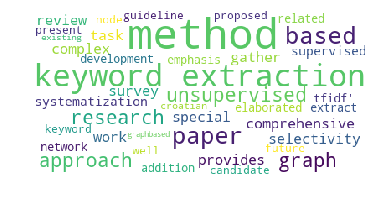

In [49]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=1.0,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [117]:
list(cv.vocabulary_.keys())[:20]

TypeError: 'list' object is not callable

            Word  Freq
0        keyword     7
1     extraction     6
2         method     6
3          paper     3
4          based     3
5          graph     2
6       approach     2
7       research     2
8   unsupervised     2
9           work     1
10       network     1
11        gather     1
12      provides     1
13         tfidf     1
14        survey     1
15        review     1
16    supervised     1
17       special     1
18    elaborated     1
19      proposed     1


[Text(0,0,'keyword'),
 Text(0,0,'extraction'),
 Text(0,0,'method'),
 Text(0,0,'paper'),
 Text(0,0,'based'),
 Text(0,0,'graph'),
 Text(0,0,'approach'),
 Text(0,0,'research'),
 Text(0,0,'unsupervised'),
 Text(0,0,'work'),
 Text(0,0,'network'),
 Text(0,0,'gather'),
 Text(0,0,'provides'),
 Text(0,0,'tfidf'),
 Text(0,0,'survey'),
 Text(0,0,'review'),
 Text(0,0,'supervised'),
 Text(0,0,'special'),
 Text(0,0,'elaborated'),
 Text(0,0,'proposed')]

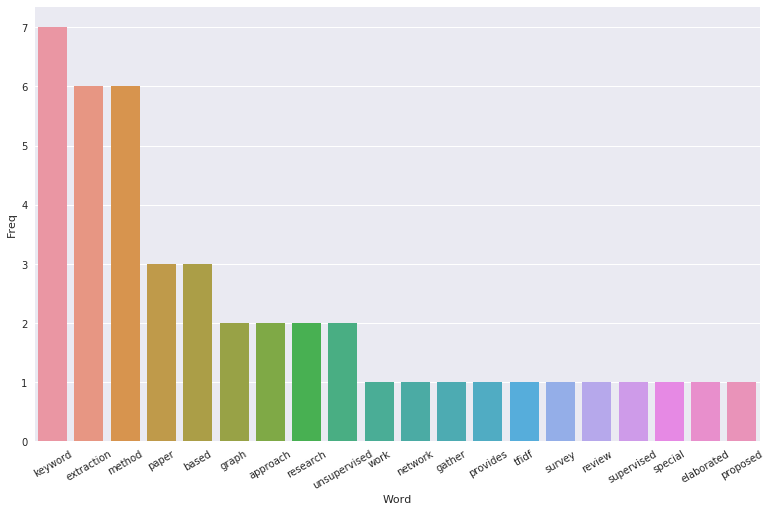

In [51]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                     Bi-gram  Freq
0         keyword extraction     6
1           approach keyword     2
2          extraction method     2
3              based keyword     2
4                graph based     2
5          keyword candidate     1
6       gather comprehensive     1
7           special emphasis     1
8             method special     1
9              survey method     1
10              paper gather     1
11               method well     1
12      comprehensive review     1
13           candidate paper     1
14            paper provides     1
15         selectivity based     1
16           future research     1
17  addition systematization     1
18         graphbased method     1
19       emphasis graphbased     1


[Text(0,0,'keyword extraction'),
 Text(0,0,'approach keyword'),
 Text(0,0,'extraction method'),
 Text(0,0,'based keyword'),
 Text(0,0,'graph based'),
 Text(0,0,'keyword candidate'),
 Text(0,0,'gather comprehensive'),
 Text(0,0,'special emphasis'),
 Text(0,0,'method special'),
 Text(0,0,'survey method'),
 Text(0,0,'paper gather'),
 Text(0,0,'method well'),
 Text(0,0,'comprehensive review'),
 Text(0,0,'candidate paper'),
 Text(0,0,'paper provides'),
 Text(0,0,'selectivity based'),
 Text(0,0,'future research'),
 Text(0,0,'addition systematization'),
 Text(0,0,'graphbased method'),
 Text(0,0,'emphasis graphbased')]

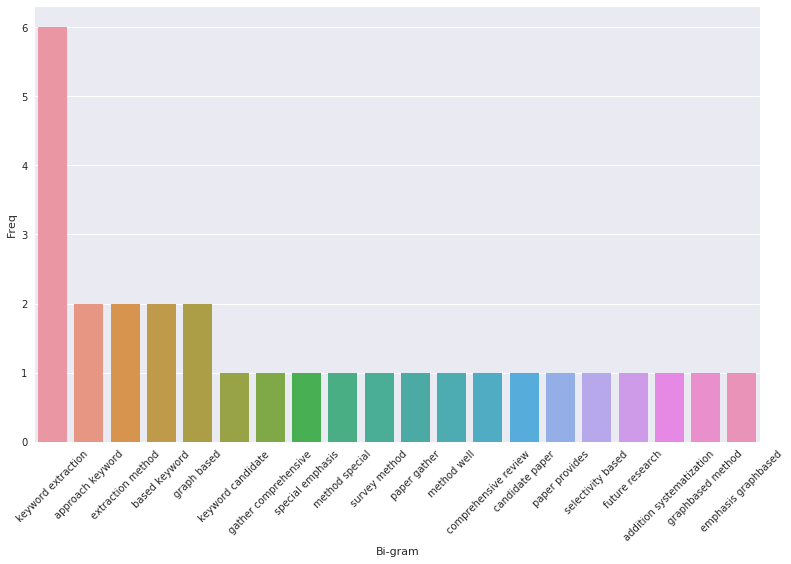

In [52]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                            Tri-gram  Freq
0        approach keyword extraction     2
1          keyword extraction method     2
2           based keyword extraction     2
3     keyword extraction selectivity     1
4            method special emphasis     1
5            method approach keyword     1
6                method paper gather     1
7            work keyword extraction     1
8        unsupervised method special     1
9     supervised unsupervised method     1
10  extraction elaborated supervised     1
11     comprehensive review existing     1
12              related work keyword     1
13             present survey method     1
14         existing research related     1
15     keyword extraction elaborated     1
16   addition systematization method     1
17               method extract node     1
18         extraction method extract     1
19      extraction selectivity based     1


[Text(0,0,'approach keyword extraction'),
 Text(0,0,'keyword extraction method'),
 Text(0,0,'based keyword extraction'),
 Text(0,0,'keyword extraction selectivity'),
 Text(0,0,'method special emphasis'),
 Text(0,0,'method approach keyword'),
 Text(0,0,'method paper gather'),
 Text(0,0,'work keyword extraction'),
 Text(0,0,'unsupervised method special'),
 Text(0,0,'supervised unsupervised method'),
 Text(0,0,'extraction elaborated supervised'),
 Text(0,0,'comprehensive review existing'),
 Text(0,0,'related work keyword'),
 Text(0,0,'present survey method'),
 Text(0,0,'existing research related'),
 Text(0,0,'keyword extraction elaborated'),
 Text(0,0,'addition systematization method'),
 Text(0,0,'method extract node'),
 Text(0,0,'extraction method extract'),
 Text(0,0,'extraction selectivity based')]

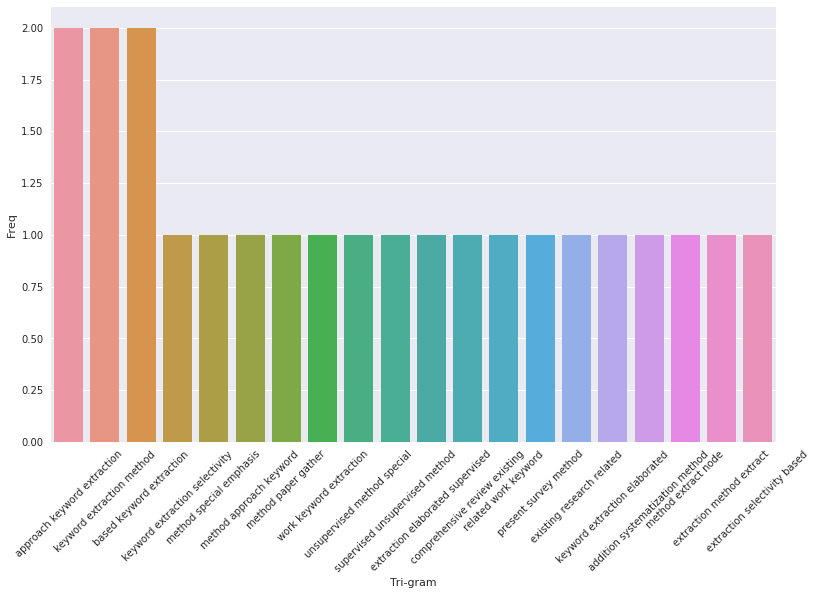

In [53]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[0]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [55]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=20):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 20
keywords=extract_topn_from_vector(feature_names,sorted_items,20)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])



Abstract:
paper present survey method approach keyword extraction task addition systematization method paper gather comprehensive review existing research related work keyword extraction elaborated supervised unsupervised method special emphasis graphbased method well croatian keyword extraction selectivity based keyword extraction method proposed unsupervised graph based keyword extraction method extract node complex network keyword candidate paper provides guideline future research development graph based approach keyword extraction tfidf

Keywords:
approach 0.107
extraction 0.32
graph based 0.107
unsupervised 0.107
approach keyword extraction 0.107
work 0.053
keyword extraction method 0.107
method 0.32
keyword 0.373
based 0.16
approach keyword 0.107
work keyword 0.053
graph 0.107
extraction method 0.107
based keyword extraction 0.107
based keyword 0.107
keyword extraction 0.32
work keyword extraction 0.053
research 0.107
paper 0.16


In [56]:
# intersection of rake and lda
final_keywords_set=set(final_keywords)
print(final_keywords_set)

{'extraction', 'new', 'task', 'method', 'keyword', 'graph', 'unsupervised', 'research', 'paper'}


In [57]:
# keywords from nlp
keywords_set=set(keywords)
print(keywords_set)

{'research', 'work', 'approach keyword extraction', 'method', 'work keyword extraction', 'approach keyword', 'graph', 'based keyword', 'approach', 'extraction', 'paper', 'graph based', 'keyword extraction method', 'keyword', 'based keyword extraction', 'based', 'unsupervised', 'extraction method', 'keyword extraction', 'work keyword'}


In [58]:
# intersection of rake,lda,nlp
print(final_keywords_set.intersection(keywords_set))

{'extraction', 'method', 'keyword', 'unsupervised', 'graph', 'research', 'paper'}


In [ ]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

In [60]:
model.fit(tf_idf_vector)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

ValueError: n_samples=1 should be >= n_clusters=2

In [ ]:
for i in range(true_k):
 print("Cluster %d:" % i),
 for ind in order_centroids[i, :10]:
   print(' %s' % terms[ind])